In [1]:
from data.dataset import TrashnetDataset
import pandas as pd
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
from torchvision.models import resnet50, resnet18
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import tempfile
import seaborn as sns
from torchmetrics import (
    MetricCollection,
    Accuracy,
    Precision,
    Recall,
    F1Score,
    ConfusionMatrix,
    AUROC
)

import mlflow
from lightning.pytorch.loggers import MLFlowLogger
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers.neptune import NeptuneLogger

/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
train_df = pd.read_csv('./data/dataset/labels-aux-1/labels_aux_train_1.csv')
val_df = pd.read_csv('./data/dataset/labels-aux-1/labels_aux_val_1.csv')
test_df = pd.read_csv('./data/dataset/labels-aux-1/labels_aux_test_1.csv')
train_df

,image_name,class_id,class_name
0,7b8eefef2ad67a78c8dc980788829aa6.jpg,4,plastic
1,ccae50bf4a6b1caae086873ab815392d.jpg,2,metal
2,9df4df47ae2e0cf776c8492cccd1463a.jpg,3,paper
3,05a67edfc93bcde7ddd2d31cc1833933.jpg,1,glass
4,63f7a25b0d426843ddecb0a81636ac2d.jpg,5,trash
...,...,...,...
211,72dd000b31da0d8963a81184373fe798.jpg,3,paper
212,25dc8352df86fe64de523bd9e4201fae.jpg,2,metal
213,53fcd1f0aeefc432388726e73e38fc2d.jpg,4,plastic
214,d57defb1eec094ce3c20f8d64b17a039.jpg,0,cardboard


In [3]:
# Test on entire dataset
#all_samples_df = pd.read_csv('./data/dataset/labels-all/labels_all.csv')
#train_df, val_df = train_test_split(all_samples_df, train_size=0.8)
#train_df.reset_index(drop='index', inplace=True)
#val_df.reset_index(drop='index', inplace=True)
#train_df

In [4]:
NUM_CLASSES = len(np.unique(train_df['class_id'])); NUM_CLASSES

6

In [5]:
transform = A.Compose([
    A.Normalize(TrashnetDataset.RGB_MEANS, TrashnetDataset.RGB_STD, 255),
    ToTensorV2()
])

ds = TrashnetDataset(
    images_dir='data/dataset/images/',
    images_names=train_df['image_name'],
    labels=train_df['class_id'],
    transform=transform
)
ds[0]

(0,
 tensor([[[ 0.8520,  0.8520,  0.8520,  ..., -0.6686, -0.6686, -0.6686],
          [ 0.8520,  0.8520,  0.8520,  ..., -0.6686, -0.6686, -0.6686],
          [ 0.8520,  0.8520,  0.8520,  ..., -0.6686, -0.6686, -0.6686],
          ...,
          [ 0.5516,  0.5516,  0.5516,  ..., -0.4058, -0.4058, -0.4058],
          [ 0.5516,  0.5516,  0.5516,  ..., -0.3870, -0.4058, -0.4058],
          [ 0.5516,  0.5516,  0.5516,  ..., -0.3870, -0.4058, -0.4058]],
 
         [[ 1.0435,  1.0435,  1.0435,  ..., -0.5072, -0.5072, -0.5072],
          [ 1.0435,  1.0435,  1.0435,  ..., -0.5072, -0.5072, -0.5072],
          [ 1.0435,  1.0435,  1.0435,  ..., -0.5072, -0.5072, -0.5072],
          ...,
          [ 0.7445,  0.7445,  0.7445,  ..., -0.2270, -0.2270, -0.2270],
          [ 0.7445,  0.7445,  0.7445,  ..., -0.2083, -0.2270, -0.2270],
          [ 0.7445,  0.7445,  0.7445,  ..., -0.2083, -0.2270, -0.2270]],
 
         [[ 1.3169,  1.3169,  1.3169,  ..., -0.2747, -0.2747, -0.2747],
          [ 1.3169,  1.3

In [6]:
model = resnet50(weights='IMAGENET1K_V1')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
fc_in_features_n = model.fc.in_features
model.fc = nn.Linear(fc_in_features_n, NUM_CLASSES)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
transform = A.Compose([
    A.Normalize(TrashnetDataset.RGB_MEANS, TrashnetDataset.RGB_STD, max_pixel_value=255.0),
    ToTensorV2()
])

In [10]:
train_ds = TrashnetDataset(
    images_dir='data/dataset/images/',
    images_names=train_df['image_name'],
    labels=train_df['class_id'],
    transform=transform
)

val_ds = TrashnetDataset(
    images_dir='data/dataset/images/',
    images_names=val_df['image_name'],
    labels=val_df['class_id'],
    transform=transform
)

# TODO: REMOVE THIS
#test_df = test_df.iloc[:10, :]
test_ds = TrashnetDataset(
    images_dir='data/dataset/images/',
    images_names=test_df['image_name'],
    labels=test_df['class_id'],
    transform=transform
)

val_df

,image_name,class_id,class_name
0,4aa684ab01c498d24ad72a5d76563572.jpg,0,cardboard
1,f3884c0c707405300ef0698fa0b6509a.jpg,2,metal
2,1f1d6cb4d4b22c469c3f9722a53e8602.jpg,1,glass
3,0e24992e7f8a3bf036142167407ca42d.jpg,3,paper
4,2e7ff24544dbb26d3d50cafdf3a5afcc.jpg,2,metal
5,f4a7e3d75f28baea47664b43ca6d2618.jpg,4,plastic
6,2e4404d80e5640cabbfaaa9b35b0a73f.jpg,1,glass
7,1a8d6fb46c6fbddbd9b11ab91ba1156b.jpg,3,paper
8,4d3ac011e5a6db97069bd62c103e0c3c.jpg,0,cardboard
9,c91667939859018b38ecef4be0f7c5f2.jpg,5,trash


In [11]:
TrashnetDataset.class_name_to_class_id['cardboard'], TrashnetDataset.class_id_to_class_name[0]

(0, 'cardboard')

In [12]:
train_ds_loader = DataLoader(train_ds, shuffle=True, batch_size=2)
val_ds_loader = DataLoader(val_ds, batch_size=2)
test_ds_loader = DataLoader(test_ds, batch_size=2)
val_ds_loader.dataset.images_names

0     4aa684ab01c498d24ad72a5d76563572.jpg
1     f3884c0c707405300ef0698fa0b6509a.jpg
2     1f1d6cb4d4b22c469c3f9722a53e8602.jpg
3     0e24992e7f8a3bf036142167407ca42d.jpg
4     2e7ff24544dbb26d3d50cafdf3a5afcc.jpg
5     f4a7e3d75f28baea47664b43ca6d2618.jpg
6     2e4404d80e5640cabbfaaa9b35b0a73f.jpg
7     1a8d6fb46c6fbddbd9b11ab91ba1156b.jpg
8     4d3ac011e5a6db97069bd62c103e0c3c.jpg
9     c91667939859018b38ecef4be0f7c5f2.jpg
10    eded15aa90832e6144fccb292448ef43.jpg
11    5536614c8fe4fe00c3200f4411e4e591.jpg
12    640564019832271bba671944db81abe1.jpg
13    5e1e3d96a45ae156e86be0a39ae75a79.jpg
14    77672ff349021c070033f038b8deaaff.jpg
15    7d692df144ad7d710f2f500cea91a0a2.jpg
16    fd75fbeec937d1657b24cb4a524df1d0.jpg
17    ad4bace863523a7f89e3ad84ddd84d5a.jpg
18    544b75952f51049fe87564aed2f11655.jpg
19    c0ba36e2928073a5bc4a44efc1c8f6a8.jpg
20    8e6c69560d3bb2a2e321081ea5ff9cbf.jpg
21    8477d3d9d0c21d3f692df1f1278f7786.jpg
22    f0adec2964b761825fa0a28ddae6062d.jpg
23    ce1aa

In [13]:
class TrashnetClassifier(pl.LightningModule):
    def __init__(self, classifier, loss, classes_n, **kwargs):
        super().__init__()
        self.classifier = classifier
        self.loss = loss
        self.classes_n = classes_n
        self.per_image_test_loss = ['image_name, loss\n']
        self.idx_to_image_name_test = kwargs.get('idx_to_image_name_test')

        self.val_metrics = MetricCollection(
            {
                "accuracy_micro": Accuracy(
                    task="multiclass", num_classes=classes_n, average='micro'
                ),
                "precision": Precision(
                    task="multiclass", num_classes=classes_n, average='none'
                ),
                "recall": Recall(
                    task="multiclass", num_classes=classes_n, average='none'
                ),
                "f1_score": F1Score(
                    task="multiclass", num_classes=classes_n, average='none'
                ),
                "auroc": AUROC(
                    task="multiclass", num_classes=classes_n, average='none'
                )
            },
        )
        self.test_metrics = self.val_metrics.clone()
        self.test_metrics.add_metrics(
            {
                'confusion_matrix': ConfusionMatrix(
                task='multiclass', num_classes=classes_n
                )
            }
        )

    ################################################################################
    # Training                                                                     #
    ################################################################################
    def training_step(self, batch, batch_idx):
        _, x, targets = batch
        preds = self.classifier(x)
        loss = self.loss(preds, targets)
        return loss

    ################################################################################
    # Validation                                                                   #
    ################################################################################
    def validation_step(self, batch, batch_idx):
        _, x, targets = batch
        preds = self.classifier(x)
        loss = self.loss(preds, targets)
        self.val_metrics.update(preds, targets)
        return loss

    def on_validation_epoch_end(self):
        computed_metrics = self.val_metrics.compute()
        self._log_val_metrics(computed_metrics)
        self.val_metrics.reset()

    def _log_val_metrics(self, computed_metrics):
        self.log('val/accuracy_micro', computed_metrics.pop('accuracy_micro'))
        for metric_name, metric_values in computed_metrics.items():
            for i, value in enumerate(metric_values):
                class_name = TrashnetDataset.class_id_to_class_name[i]
                self.log(f'val/per_class/{class_name}/{metric_name}', value)

    ################################################################################
    # Testing                                                                      #
    ################################################################################
    def test_step(self, batch, batch_idx):
        idxs, x, targets = batch
        preds = self.classifier(x)
        self.test_metrics.update(preds, targets)
        # Log loss for each image separately for later human evaluation
        for idx, pred, target in zip(idxs, preds, targets):
            loss = self.loss(pred, target)
            self.per_image_test_loss.append(
                f"{self.idx_to_image_name_test[idx]}, {loss}\n"
            )

    def on_test_epoch_end(self):
        computed_metrics = self.test_metrics.compute()
        self._log_test_metrics(computed_metrics)
        self._log_test_loss()
        self.test_metrics.reset()

    def _log_test_metrics(self, computed_metrics):
        self.log('test/accuracy_micro', computed_metrics.pop('accuracy_micro'))
        heatmap_figure = sns.heatmap(
            computed_metrics.pop('confusion_matrix').cpu(),
            xticklabels=TrashnetDataset.class_id_to_class_name,
            yticklabels=TrashnetDataset.class_id_to_class_name,
            annot=True
        ).figure # TODO: Normalize
        self.logger.experiment.log_figure(self.logger.run_id, heatmap_figure, 'confusion_matrix.png')
        for metric_name, metric_values in computed_metrics.items():
            for i, value in enumerate(metric_values):
                class_name = TrashnetDataset.class_id_to_class_name[i]
                self.log(f'test/per_class/{class_name}/{metric_name}', value)

    def _log_test_loss(self):
        # https://stackoverflow.com/questions/55822637/
        with tempfile.TemporaryDirectory() as tempdir:
            filepath = os.path.join(tempdir, 'per_image_loss.csv')
            with open(filepath, 'w') as file:
                file.writelines(self.per_image_test_loss)
            self.logger.experiment.log_artifact(self.logger.run_id, filepath)

    ################################################################################
    # Other                                                                        #
    ################################################################################
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [14]:
mlflow.pytorch.autolog()

In [15]:
predictor = TrashnetClassifier(model, loss, 6, idx_to_image_name_test=list(test_ds.images_names))

In [16]:
with mlflow.start_run() as run:
    mlflow_logger = MLFlowLogger(run_id=run.info.run_id)
    trainer = pl.Trainer(
        max_epochs=3,
        accumulate_grad_batches=64,
        logger=mlflow_logger
        #callbacks=[
            #EarlyStopping(monitor='auroc_macro', mode=)
        #]
    )

    trainer.fit(
        model=predictor,
        train_dataloaders=val_ds_loader, # TODO: CHANGE THIS
        val_dataloaders=val_ds_loader
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/10/11 08:38:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:351: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.8 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | classifier   | ResNet           | 23.5 M
1 | loss         | CrossEntropyLoss | 0     
2 | val_metrics  | MetricCollection | 0     
3 | test_metrics | MetricCollection | 0     
--------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.081    Total estima

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs 

Epoch 2: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s, v_num=b87c]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s, v_num=b87c]


2023/10/11 08:39:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at ./mlruns/0/957fddaeff8c42d780f9b51e5a71b87c/checkpoints/epoch=2-step=3.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/0/957fddaeff8c42d780f9b51e5a71b87c/checkpoints/epoch=2-step=3.ckpt
/home/js/miniconda3/envs/custom-yolov7/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Testing DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric             ┃            DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/accuracy_micro         │                0.5                 │
│   test/per_class/cardboard/auroc   │         0.9624999761581421         │
│ test/per_class/cardboard/f1_score  │         0.4000000059604645         │
│ test/per_class/cardboard/precision │                1.0                 │
│  test/per_class/cardboard/recall   │                0.25                │
│     test/per_class/glass/auroc     │                1.0                 │
│   test/per_class/glass/f1_score    │         0.7272727489471436         │
│   test/per_class/glass/precision   │         0.5714285969734192         │
│    test/per_class/glass/recall     │                1.0                 │
│     test/per_class/metal/auroc     │         0.6124999523162842         │
│   test/per_class/metal/f1_score    │               0.375                │
│   test/per_class/metal/precision   │                0.25                │
│    test/per_class/metal/recall     │                0.75                │
│     test/per_class/paper/auroc     │         0.8500000238418579         │
│   test/per_class/paper/f1_score    │                0.0                 │
│   test/per_class/paper/precision   │                0.0                 │
│    test/per_class/paper/recall     │                0.0                 │
│    test/per_class/plastic/auroc    │                1.0                 │
│  test/per_class/plastic/f1_score   │                1.0                 │
│  test/per_class/plastic/precision  │                1.0                 │
│   test/per_class/plastic/recall    │                1.0                 │
│     test/per_class/trash/auroc     │         0.7875000238418579         │
│   test/per_class/trash/f1_score    │                0.0                 │
│   test/per_class/trash/precision   │                0.0                 │
│    test/per_class/trash/recall     │                0.0                 │
└────────────────────────────────────┴────────────────────────────────────┘

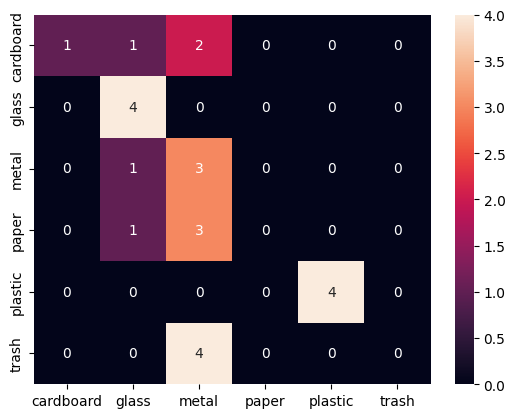

In [17]:
trainer.test(dataloaders=(val_ds_loader)) # TODO: CHANGE THIS
mlflow.end_run()

In [18]:
cm = trainer.run_history.get_latest_metric('confusion_matrix')

AttributeError: 'Trainer' object has no attribute 'run_history'